# Image denoising (part II)

The objective of this exercise is implementing several advanced image denoising techniques

## Anisotropic diffusion

In diffusion approaches, a finite difference scheme is used to remove the noise.

Given the following structure:

1. Implement the linear diffusion approach.

2. Implement the Perona-Malik diffusion technique.
    
    2.1. Consider the two diffusivity functions proposed in the paper (see Eqs. 16 and 17 in Lecture 2).
 
    2.2. Implement a third diffusion approach using regularized gradients in diffusivity (see Eqs. 25 and 26 in Lecture 2).


3. Show how the number of iterations and the parameter lambda (in the case of the anisotropic diffusion) affect the results.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from skimage.util import random_noise
from skimage import data

import cv2
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = [16,8]


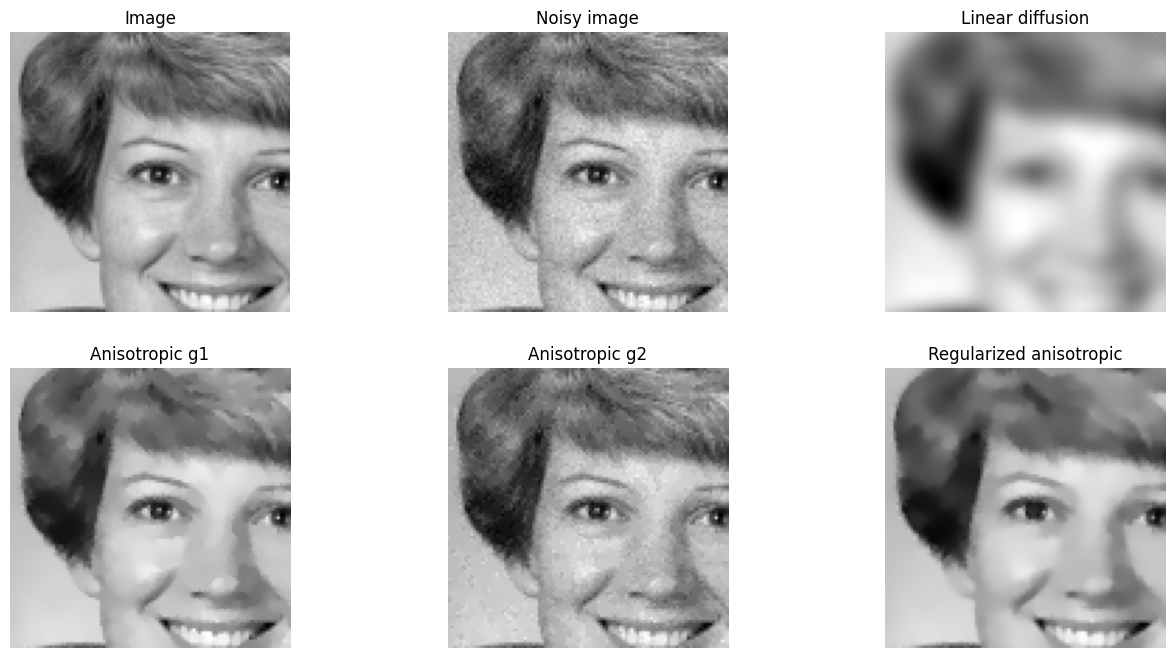

In [2]:
def linear_step(im, **kwargs):
    
    laplacian=  cv2.Laplacian(im, cv2.CV_64F)

    return laplacian
    
    
def anisotropic_step_g1(im, **kwargs):
    
    lmbda= kwargs['lmbda']
    
    deriv_kernel= np.array([[-0.5, 0, 0.5]])
    
    #computes the horizontal and vertical gradients
    ux = cv2.filter2D(im, -1, deriv_kernel)
    uy = cv2.filter2D(im, -1, deriv_kernel.T)
    
    s= np.sqrt(ux**2 + uy**2) 
    g=1/(1+(s/lmbda)**2)
   
    
    ##
    right_kernel= np.array([[0, -1, 1]])
    left_kernel= np.array([[-1, 1, 0]])
    down_kernel= right_kernel.T
    up_kernel= left_kernel.T
    
    u1=cv2.filter2D(im, -1, right_kernel)
    u2=cv2.filter2D(im, -1, left_kernel)
    u3=cv2.filter2D(im, -1, down_kernel)
    u4=cv2.filter2D(im, -1, up_kernel)
    
    ##
    right_half_kernel=  np.array([[0, 0.5, 0.5]])
    left_half_kernel= np.array([[0.5, 0.5, 0]])
    down_half_kernel=right_half_kernel.T
    up_half_kernel=left_half_kernel.T
    
    g1= cv2.filter2D(g, -1, right_half_kernel)
    g2= cv2.filter2D(g, -1, left_half_kernel)
    g3= cv2.filter2D(g, -1, down_half_kernel)
    g4= cv2.filter2D(g, -1, up_half_kernel) 
    
    grad= g1*u1 - g2*u2 + g3*u3 - g4*u4

    return grad

def anisotropic_step_g2(im, **kwargs):
    
    lmbda= kwargs['lmbda']
    
    deriv_kernel= np.array([[-0.5, 0, 0.5]])
    #computes the horizontal and vertical gradients
    ux = cv2.filter2D(im, -1, deriv_kernel)
    uy = cv2.filter2D(im, -1, deriv_kernel.T)
    s= np.sqrt(ux**2 + uy**2)
    
    g= np.exp(-(s/lmbda)**2 )
        
    
    ##
    right_kernel= np.array([[0, -1, 1]])
    left_kernel= np.array([[-1, 1, 0]])
    down_kernel= right_kernel.T
    up_kernel= left_kernel.T
    
    u1=cv2.filter2D(im, -1, right_kernel)
    u2=cv2.filter2D(im, -1, left_kernel)
    u3=cv2.filter2D(im, -1, down_kernel)
    u4=cv2.filter2D(im, -1, up_kernel)
    
    ##
    right_half_kernel=  np.array([[0, 0.5, 0.5]])
    left_half_kernel= np.array([[0.5, 0.5, 0]])
    down_half_kernel=right_half_kernel.T
    up_half_kernel=left_half_kernel.T
    
    g1= cv2.filter2D(g, -1, right_half_kernel)
    g2= cv2.filter2D(g, -1, left_half_kernel)
    g3= cv2.filter2D(g, -1, down_half_kernel)
    g4= cv2.filter2D(g, -1, up_half_kernel)
    
    
    grad= g1*u1 - g2*u2 + g3*u3 - g4*u4

    
    return grad

def regularized_anisotropic_step(im, **kwargs):
    
    lmbda= kwargs['lmbda']
    sigma= kwargs['sigma']
    
    d_kernel= np.array([[-0.5, 0, 0.5]])
        
    im_gauss = cv2.GaussianBlur(im, (5, 5), 0)
 
    ux = cv2.filter2D(im_gauss, -1, d_kernel)
    uy = cv2.filter2D(im_gauss, -1, d_kernel.T)
    s= np.sqrt(ux**2 + uy**2)
    
    g=1/(1+(s/lmbda)**2)        
   
    
    next_n_kernel= np.array([[0, -1, 1]])
    prev_n_kernel= np.array([[-1, 1, 0]])
    
    plus_half_kernel=  np.array([[0, 0.5, 0.5]])
    minus_half_kernel= np.array([[0.5, 0.5, 0]])
    
    u1=cv2.filter2D(im, -1, next_n_kernel)
    u2=cv2.filter2D(im, -1, prev_n_kernel)
    u3=cv2.filter2D(im, -1, next_n_kernel.T)
    u4=cv2.filter2D(im, -1, prev_n_kernel.T)
    
    g1= cv2.filter2D(g, -1, plus_half_kernel)
    g2= cv2.filter2D(g, -1, minus_half_kernel)
    g3= cv2.filter2D(g, -1, plus_half_kernel.T)
    g4= cv2.filter2D(g, -1, minus_half_kernel.T)
    
    grad= g1*u1 - g2*u2 + g3*u3 - g4*u4

    return grad

def diffusion(im, iterations, func, t, **kwargs):

    #print('func', func)
    u_t=im
    learning_rate= t 
    
    for x in range(iterations):
        step= func(im, **kwargs)
        im_new= im + step*learning_rate
        
        im=im_new
            

    return im


im = data.astronaut()[:,:,1].astype(np.float32)/255
noisy = random_noise(im, var=0.001)
     
iterations = 25
t = 0.25
linear_result = diffusion(noisy,iterations, linear_step, t)
ad1_result = diffusion(noisy, iterations, anisotropic_step_g1, t, lmbda=0.01)
ad2_result = diffusion(noisy, iterations, anisotropic_step_g2, t, lmbda=0.01)
ad3_result = diffusion(noisy, iterations, regularized_anisotropic_step, t, lmbda=0.01, sigma= 1)


fig, ax = plt.subplots(2,3)
titles = [['Image', 'Noisy image', 'Linear diffusion'], ['Anisotropic g1', 'Anisotropic g2', 'Regularized anisotropic']]
images = [[im, noisy, linear_result], [ad1_result, ad2_result, ad3_result]]
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].axis('off')
        ax[i,j].title.set_text(titles[i][j])
        ax[i,j].imshow(images[i][j][50:150,150:250], cmap='gray')
plt.show()

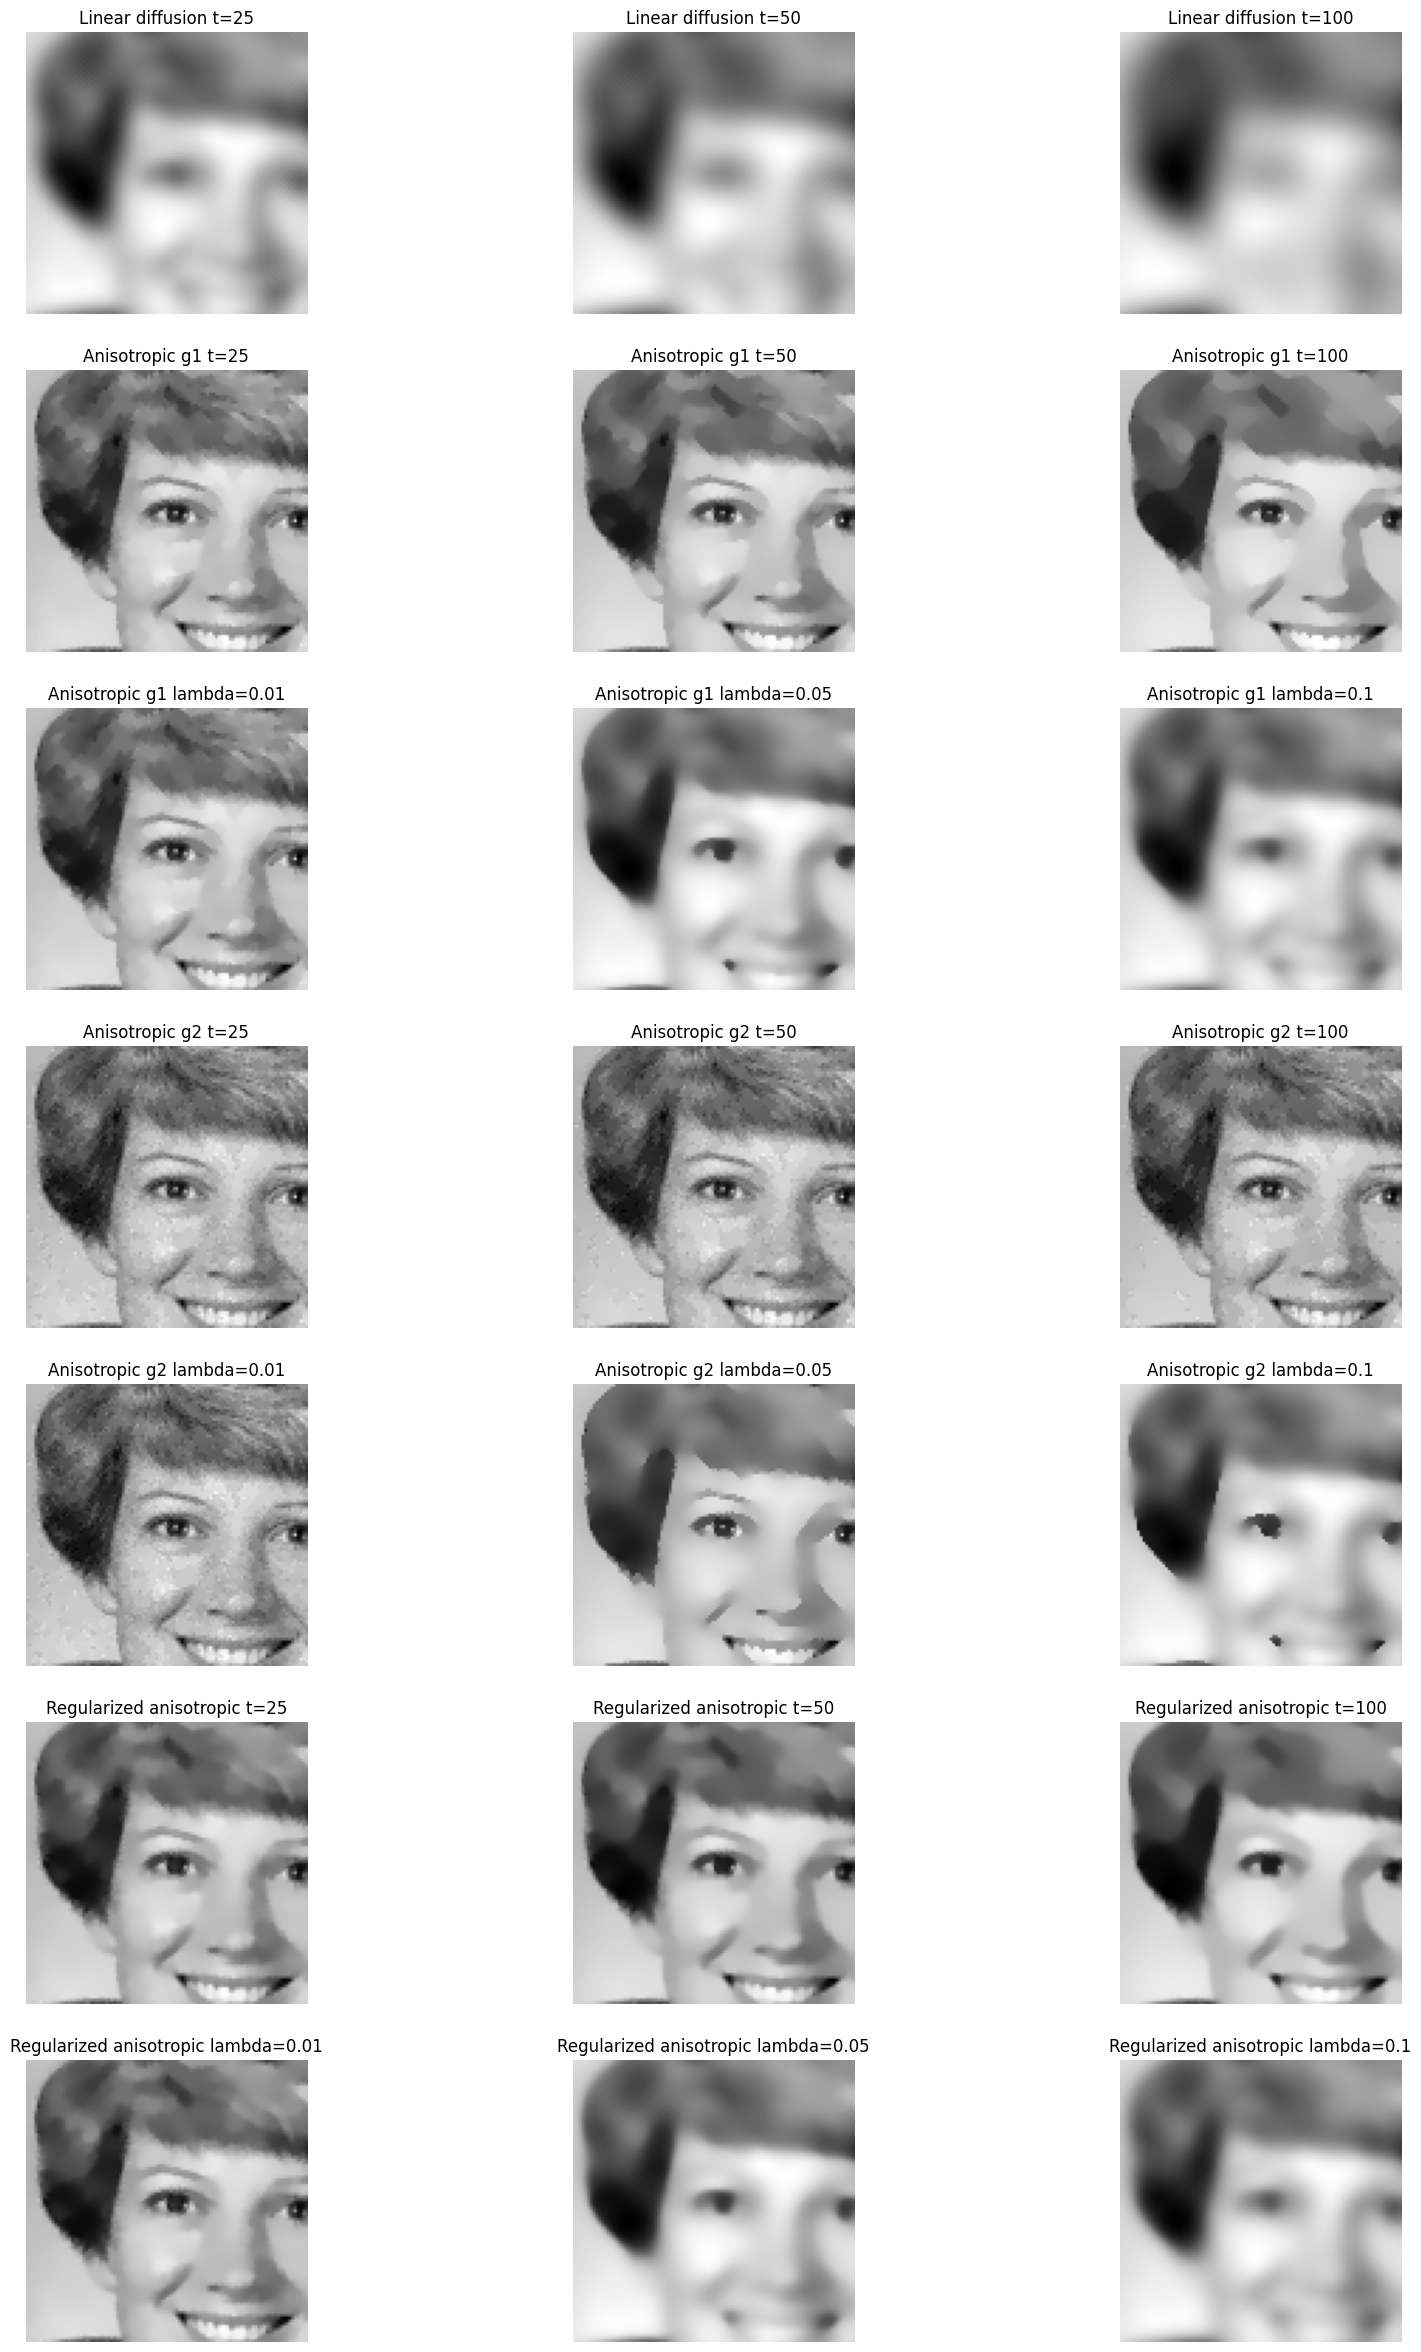

In [3]:
#3. Show how the number of iterations and the parameter lambda (in the case of the anisotropic diffusion) affect the results.


iterations = 25
t = 0.25
#Linear different iterations
linear_result_1 = diffusion(noisy, 25,  linear_step, t)
linear_result_2 = diffusion(noisy, 50, linear_step, t)
linear_result_3 = diffusion(noisy, 100, linear_step, t)

##anisotropic_step_g1
#different iterations
ad1_result_1 = diffusion(noisy, 25, anisotropic_step_g1, t, lmbda=0.01)
ad1_result_2 = diffusion(noisy, 50, anisotropic_step_g1, t, lmbda=0.01)
ad1_result_3 = diffusion(noisy, 100, anisotropic_step_g1, t, lmbda=0.01)

#different lambda
ad1_result_a = diffusion(noisy, 25, anisotropic_step_g1, t, lmbda=0.01)
ad1_result_b = diffusion(noisy, 25, anisotropic_step_g1, t, lmbda=0.05)
ad1_result_c = diffusion(noisy, 25, anisotropic_step_g1, t, lmbda=0.1)

##anisotropic_step_g2
#different iterations
ad2_result_1 = diffusion(noisy, 25, anisotropic_step_g2, t, lmbda=0.01)
ad2_result_2 = diffusion(noisy, 50, anisotropic_step_g2, t, lmbda=0.01)
ad2_result_3 = diffusion(noisy, 100, anisotropic_step_g2, t, lmbda=0.01)

#different lambda
ad2_result_a = diffusion(noisy, 25, anisotropic_step_g2, t, lmbda=0.01)
ad2_result_b = diffusion(noisy, 25, anisotropic_step_g2, t, lmbda=0.05)
ad2_result_c = diffusion(noisy, 25, anisotropic_step_g2, t, lmbda=0.1)

##regularized_anisotropic_step
#different lambda
ad3_result_1 = diffusion(noisy, 25, regularized_anisotropic_step, t, lmbda=0.01, sigma=1)
ad3_result_2 = diffusion(noisy, 50, regularized_anisotropic_step, t, lmbda=0.01, sigma=1)
ad3_result_3 = diffusion(noisy, 100, regularized_anisotropic_step, t, lmbda=0.01, sigma=1)

#different lambda
ad3_result_a = diffusion(noisy, 25, regularized_anisotropic_step, t, lmbda=0.01, sigma=1)
ad3_result_b = diffusion(noisy, 25, regularized_anisotropic_step, t, lmbda=0.05, sigma=1)
ad3_result_c = diffusion(noisy, 25, regularized_anisotropic_step, t, lmbda=0.1, sigma=1)

fig_width = 20  
fig_height = 30  

fig, ax = plt.subplots(7, 3, figsize=(fig_width, fig_height))


titles = [['Linear diffusion t=25', 'Linear diffusion t=50', 'Linear diffusion t=100'], 
          ['Anisotropic g1 t=25', 'Anisotropic g1 t=50', 'Anisotropic g1 t=100'], 
          ['Anisotropic g1 lambda=0.01', 'Anisotropic g1 lambda=0.05', 'Anisotropic g1 lambda=0.1'],
          ['Anisotropic g2 t=25', 'Anisotropic g2 t=50', 'Anisotropic g2 t=100'], 
          ['Anisotropic g2 lambda=0.01', 'Anisotropic g2 lambda=0.05', 'Anisotropic g2 lambda=0.1'], 
          ['Regularized anisotropic t=25', 'Regularized anisotropic t=50', 'Regularized anisotropic t=100'],
          ['Regularized anisotropic lambda=0.01', 'Regularized anisotropic lambda=0.05', 'Regularized anisotropic lambda=0.1']
          ]

images = [[linear_result_1, linear_result_2, linear_result_3], 
          [ad1_result_1, ad1_result_2, ad1_result_3],
          [ad1_result_a, ad1_result_b, ad1_result_c],
          [ad2_result_1, ad2_result_2, ad2_result_3],
          [ad2_result_a, ad2_result_b, ad2_result_c],
          [ad3_result_1, ad3_result_2, ad3_result_3],
          [ad3_result_a, ad3_result_b, ad3_result_c]
          ]
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].axis('off')
        ax[i,j].title.set_text(titles[i][j])
        ax[i,j].imshow(images[i][j][50:150,150:250], cmap='gray')
plt.show()



3. Show how the number of iterations and the parameter lambda (in the case of the anisotropic diffusion) affect the results.

In all methods, the number of iterations leads to smoother images. This is expected because more diffusion steps are applied, leading to more noise removal, but also loss of image details. 

For anisotropic diffusion, the method diffuses regions of uniform intensity while preserving the edges. Gradient magnitudes greater than λ are considered edges, and the diffusion in these regions is reduced to preserve these features. Gradient magnitudes lower than  λ are not considered edges, and the regions undergo more diffusion, resulting in smoother areas.
Hence, with a higher lambda value, there is a much greater loss of edges, causing blurring and loss of image details.
For anisotropic diffusion, increasing the number of iterations has a smaller impact on loss of edges than the lambda value, because the "edge threshold" is the same, instead occurring a higher smoothing of the image.

In linear diffusion, the important features of the images get very blurred, leading to a big loss of information. 

We can also observe that the lambda parameter has a bigger effect on g1 than on g2. This is due to the diffusivity function used, where the same lambda value has a bigger impact on the result.

